<a href="https://colab.research.google.com/drive/1amJQbcLRo1pvQB9rUTFrWzqSltVnTsYL?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

# Optimize a random input image in a way to maximize the activations of some neuron(s)

This approach is interesting that it tells us what kind of input excites a neuron or a set of neurons. Neurons learn to be feature detectors, and they get excited when a feature is found in the input. Usually, layers near the input are excited by basic or low level features (lines, curves, textures, colors), while deep layers are excited by high level feature (objects: faces, vehicles, animals).   

## Steps:
- Start with a random input image
- Keep the network weights fixed
- Use gradient ascent to update the input image in the direction to maximize the output 
- Plot the image   

## Pre trained networs
- VGG16
- you can try Inception_v3 

In [0]:
import time
import numpy as np
from PIL import Image as pil_image
from keras import layers
from keras import applications
from keras.applications import vgg16
from keras import backend as K
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm_notebook as tqdm

In [32]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
print(K.image_data_format())

channels_last


In [33]:
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')  #weights='imagenet'

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

for layer in model.layers:
  print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
# filter_index can be any integer from 0 to 511, as there are 512 filters in that layer
loss = K.mean(layer_dict['block5_conv3'].output[:, :, :, np.random.randint(0,20):512:np.random.randint(50,100)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) 0 254
(1, 224, 224, 3) -123.68 150.061


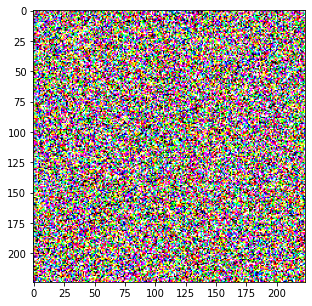

In [35]:
import numpy as np

img_width = 224
img_height  = 224

# we start from a gray image with some noise
# input_img_data = np.random.random((1, img_width, img_height, 3)) #* 20 + 128.

input_img_data = np.random.randint(0,255,(1, img_width, img_height, 3))
print(input_img_data.shape, np.min(input_img_data), np.max(input_img_data))
input_img_data = vgg16.preprocess_input(input_img_data)
print(input_img_data.shape, np.min(input_img_data), np.max(input_img_data))

plt.figure(figsize=(5,5))
plt.imshow(input_img_data[0])

In [0]:
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, model.input)[0]

# normalization trick: we normalize the gradient
grads /= K.std(grads) + 1e-8

# this function returns the loss and grads given the input picture
iterate = K.function([model.input], [loss, grads])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


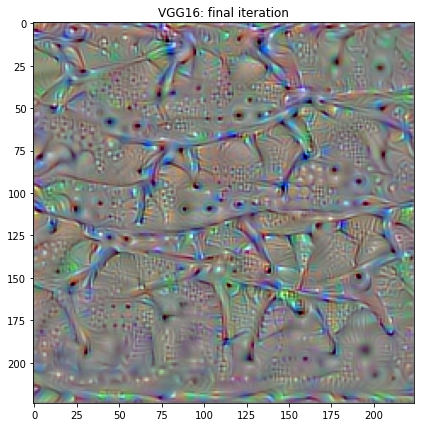

In [37]:
# run gradient ascent for n steps
images = []
loss_list = []

for i in tqdm(range(800)):
    loss_value, grads_value = iterate([input_img_data])
    loss_list.append(loss_value)
    input_img_data += grads_value * 0.01
    if(i%5 == 0):
      #print(i, loss_value, np.mean(grads_value), np.std(grads_value))
      img = input_img_data[0]
      img = deprocess_image(img)
      images.append(img)

img = input_img_data[0]
img = deprocess_image(img)
images.append(img)
plt.figure(figsize=(7,7))
plt.title('VGG16: final iteration')
plt.imshow(img)

Note: If you did not get a good looing output, don't panic. Just run the code again to select different set  of neurons. 

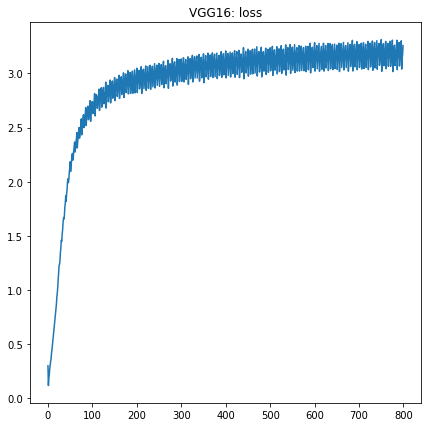

In [38]:
# plot the loss
plt.figure(figsize=(7,7))
plt.title('VGG16: loss')
plt.plot(loss_list)

The loss curve above is going up  because we conduct gradient descent to maximize the output. Moreover, it looks fine. 

### Let's see the optimization over time as animated gif

In [0]:
imageio.mimsave('./vgg16.gif', images[:80])

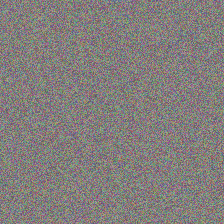

In [40]:
from IPython.display import Image
with open('./vgg16.gif','rb') as f:
    display(Image(data=f.read(), format='png'))